# COSC 6373 - HW5-ICA - Minh Nguyen #2069407

In [15]:
import tensorflow as tf
from tensorflow import keras
from keras.applications import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras import layers, models

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [16]:
# Define dataset paths
train_dir = "train"
test_dir = "test"

# Define parameters
IMG_SIZE = (256, 256)
BATCH_SIZE = 32

# Load training and validation data
# where the validation data is extracted with 20 images from each class in the training data

train_data = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    validation_split=(20/180),
    subset="training",
    seed=42
)

val_data = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    validation_split=(20/180),
    subset="validation",
    seed=42
)

# Load test dataset
test_data = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)


Found 360 files belonging to 2 classes.
Using 320 files for training.
Found 360 files belonging to 2 classes.
Using 40 files for validation.
Found 40 files belonging to 2 classes.


In [17]:
# Apply ResNet50 preprocessing
train_data = train_data.map(lambda x, y: (preprocess_input(x), y))
val_data = val_data.map(lambda x, y: (preprocess_input(x), y))
test_data = test_data.map(lambda x, y: (preprocess_input(x), y))

In [18]:
# Load ResNet50 as the base model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
base_model.trainable = False  # Freeze base model initially

In [ ]:
# Add custom layers on top
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),  # Prevent overfitting
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

In [20]:
# Freeze all layers except of the classifier layer (last layer)
base_model.layers[-1].trainable = True

# Compile the model
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
#               loss='binary_crossentropy',
#               metrics=['accuracy'])

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 8, 8, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,589,761 (89.99 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [21]:
# Train the model
history = model.fit(train_data, 
                    batch_size=BATCH_SIZE, 
                    validation_data=val_data,
                    epochs=10)


Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.5389 - loss: 0.8787 - val_accuracy: 0.8000 - val_loss: 0.5182
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.6728 - loss: 0.5839 - val_accuracy: 0.9000 - val_loss: 0.3749
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.8403 - loss: 0.3762 - val_accuracy: 0.9500 - val_loss: 0.2892
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.8916 - loss: 0.3092 - val_accuracy: 0.9500 - val_loss: 0.2484
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.9003 - loss: 0.2904 - val_accuracy: 0.9750 - val_loss: 0.1942
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.9524 - loss: 0.2072 - val_accuracy: 0.9750 - val_loss: 0.1728
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.9059 - loss: 0.2447 - val_accuracy: 0.9500 - val_loss: 0.1766
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.9459 - loss: 0.1856 - val_accuracy: 0.9750 - val_loss:

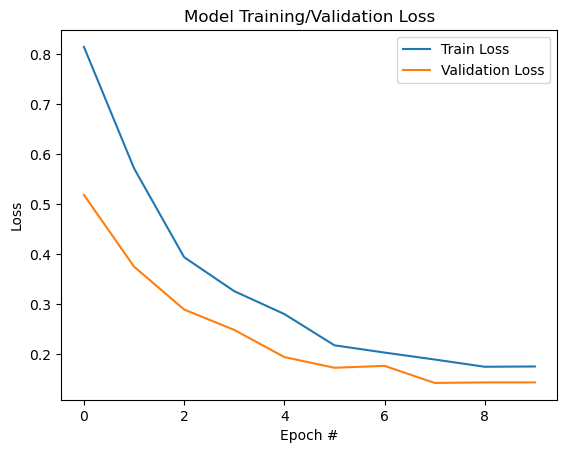

In [22]:
# Plot a training learning curve (loss-epochs) and discuss if the model is 
# over-fitted, under-fitted, or well-trained.
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training/Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch #')
plt.legend(['Train Loss', 'Validation Loss'], loc='upper right')

- From the plot, we can observe that the model appears to be relatively well-trained. The training and validation loss are both decreasing, and the validation loss curve closely follows the training loss curve. This suggests that the model is not overfitting the training data, and is generalizing well to the validation data. However, there are still possibly some room for improvement.

In [23]:
# Evaluate the model on the test data and plot the confusion matrix
test_loss, test_acc = model.evaluate(test_data)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 274ms/step - accuracy: 0.8917 - loss: 0.1605
Test Accuracy: 0.9000
Test Loss: 0.1521


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 979ms/step


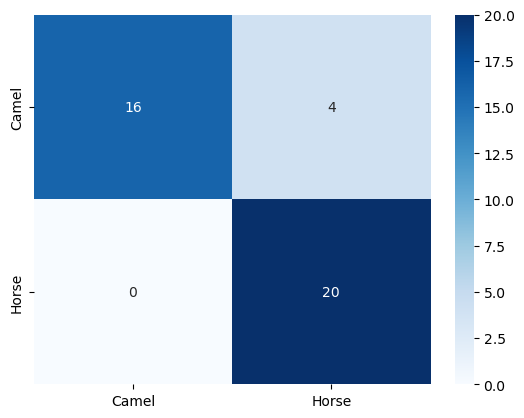

In [24]:
# Generate confusion matrix
y_pred = model.predict(test_data)
y_pred = np.round(y_pred).flatten()
y_true = np.concatenate([y for x, y in test_data], axis=0)
confusion_mtx = confusion_matrix(y_true, y_pred)
sns.heatmap(confusion_mtx, annot=True, fmt="d", cmap='Blues', xticklabels=['Camel', 'Horse'], yticklabels=['Camel', 'Horse'])
plt.show()

In [28]:
# Generate classification report
print(classification_report(y_true, y_pred, target_names=['Camel', 'Horse']))

# Calculate and report Precision
precision = confusion_mtx[1, 1] / (confusion_mtx[1, 1] + confusion_mtx[0, 1])
print(f"Precision: {precision:.4f}")

# Calculate and report Accuracy
accuracy = (confusion_mtx[0, 0] + confusion_mtx[1, 1]) / np.sum(confusion_mtx)
print(f"Accuracy: {accuracy:.4f}")

# Calculate and report Sensitivity
sensitivity = confusion_mtx[1, 1] / (confusion_mtx[1, 1] + confusion_mtx[1, 0])
print(f"Sensitivity: {sensitivity:.4f}")

# Calculate and report Specificity
specificity = confusion_mtx[0, 0] / (confusion_mtx[0, 0] + confusion_mtx[0, 1])
print(f"Specificity: {specificity:.4f}")


              precision    recall  f1-score   support

       Camel       1.00      0.80      0.89        20
       Horse       0.83      1.00      0.91        20

    accuracy                           0.90        40
   macro avg       0.92      0.90      0.90        40
weighted avg       0.92      0.90      0.90        40

Precision: 0.8333
Accuracy: 0.9000
Sensitivity: 1.0000
Specificity: 0.8000


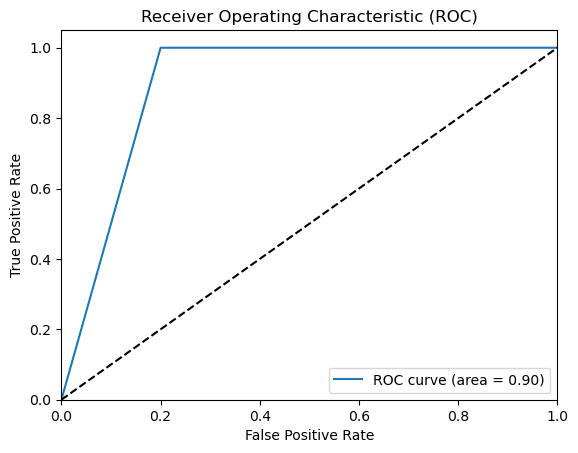

In [29]:
# Plot ROC of your trained model
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

- Now, we re-initialize the model and perform training and evaluation for the full model

In [30]:
# Re-initialize the model and perform training and evaluation for the full model

# Load ResNet50 as the base model
base_model_new = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
base_model_new.trainable = False  # Freeze base model initially

# Add custom layers on top
model_new = models.Sequential([
    base_model_new,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),  # Prevent overfitting
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

# Unfreeze all layers
base_model_new.trainable = True

# Compile the model
model_new.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Model summary
model_new.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 8, 8, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,589,761 (89.99 MB)

 Trainable params: 23,536,641 (89.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [31]:
# Train the model
history_new = model_new.fit(train_data, 
                              batch_size=BATCH_SIZE, 
                              validation_data=val_data,
                              epochs=10)

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 67s 5s/step - accuracy: 0.6611 - loss: 0.7596 - val_accuracy: 0.5250 - val_loss: 1266.7604
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 50s 5s/step - accuracy: 0.8012 - loss: 0.4847 - val_accuracy: 0.5250 - val_loss: 31747.6816
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 50s 5s/step - accuracy: 0.8445 - loss: 0.3319 - val_accuracy: 0.5250 - val_loss: 117605.3906
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 48s 5s/step - accuracy: 0.8904 - loss: 0.2838 - val_accuracy: 0.5250 - val_loss: 16842.5215
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 50s 5s/step - accuracy: 0.9427 - loss: 0.1979 - val_accuracy: 0.5250 - val_loss: 816.0588
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 51s 5s/step - accuracy: 0.9563 - loss: 0.1701 - val_accuracy: 0.5250 - val_loss: 3245.1472
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 52s 5s/step - accuracy: 0.9735 - loss: 0.0987 - val_accuracy: 0.5250 - val_loss: 3257.7488
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 53s 5s/step - accuracy: 0.9573 - loss: 0.2280 - val_accu

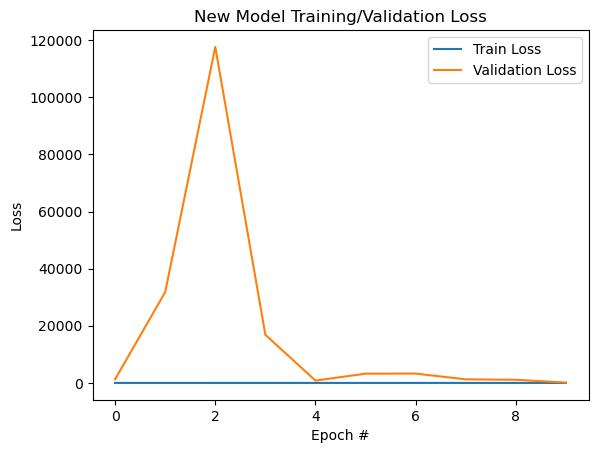

In [34]:
# Plot a training learning curve (loss-epochs) and discuss if the model is 
# over-fitted, under-fitted, or well-trained.
plt.plot(history_new.history['loss'], label='Train Loss')
plt.plot(history_new.history['val_loss'], label='Validation Loss')
plt.title('New Model Training/Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch #')
plt.legend(['Train Loss', 'Validation Loss'], loc='upper right')

In [35]:
# Evaluate the model on the test data and plot the confusion matrix
test_loss, test_acc = model_new.evaluate(test_data)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 330ms/step - accuracy: 0.4583 - loss: 103.8997
Test Accuracy: 0.5000
Test Loss: 95.9074


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 278ms/step


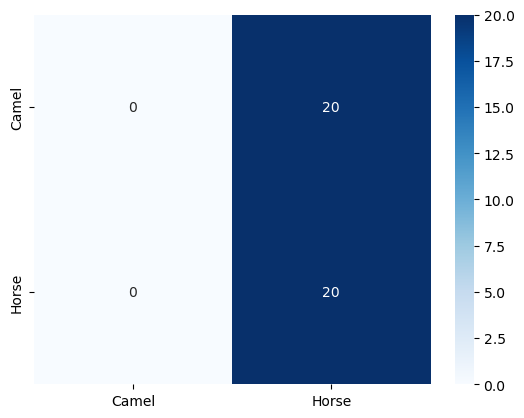

In [37]:
# Generate confusion matrix
y_pred = model_new.predict(test_data)
y_pred = np.round(y_pred).flatten()
y_true = np.concatenate([y for x, y in test_data], axis=0)
confusion_mtx_new = confusion_matrix(y_true, y_pred)
sns.heatmap(confusion_mtx_new, annot=True, fmt="d", cmap='Blues', xticklabels=['Camel', 'Horse'], yticklabels=['Camel', 'Horse'])
plt.show()

In [38]:
# Generate classification report
print(classification_report(y_true, y_pred, target_names=['Camel', 'Horse']))

# Calculate and report Precision
precision = confusion_mtx_new[1, 1] / (confusion_mtx_new[1, 1] + confusion_mtx_new[0, 1])
print(f"Precision: {precision:.4f}")

# Calculate and report Accuracy
accuracy = (confusion_mtx_new[0, 0] + confusion_mtx_new[1, 1]) / np.sum(confusion_mtx_new)
print(f"Accuracy: {accuracy:.4f}")

# Calculate and report Sensitivity
sensitivity = confusion_mtx_new[1, 1] / (confusion_mtx_new[1, 1] + confusion_mtx_new[1, 0])
print(f"Sensitivity: {sensitivity:.4f}")

# Calculate and report Specificity
specificity = confusion_mtx_new[0, 0] / (confusion_mtx_new[0, 0] + confusion_mtx_new[0, 1])
print(f"Specificity: {specificity:.4f}")

              precision    recall  f1-score   support

       Camel       0.00      0.00      0.00        20
       Horse       0.50      1.00      0.67        20

    accuracy                           0.50        40
   macro avg       0.25      0.50      0.33        40
weighted avg       0.25      0.50      0.33        40

Precision: 0.5000
Accuracy: 0.5000
Sensitivity: 1.0000
Specificity: 0.0000


/Users/ndminh/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ndminh/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ndminh/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


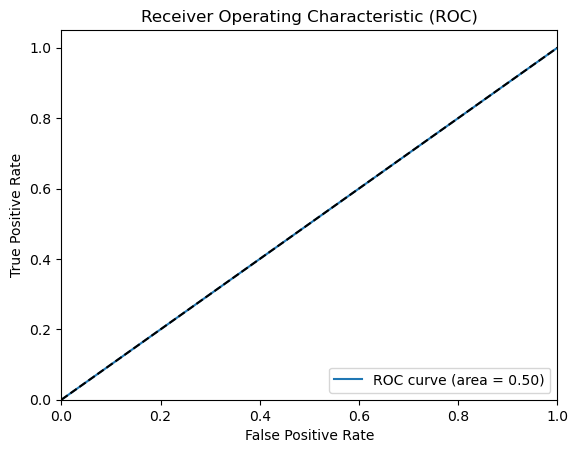

In [39]:
# Plot ROC of your trained model
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

- As we can clearly see, the model when all the layers are unfreeze performs so over-fitting. The training loss is nearly zero, while the validation loss is way too high. This is a clear sign of over-fitting. Although the validation loss drops significantly after the second epoch and then remains relatively stable, it is still higher than the training loss, which tells us that the model is still over-fitting.

1. What is a confusion matrix?
- A confusion matrix is a table that is often used to describe the performance of a classification model on a set of data for which the true values are known. It allows the visualization of the performance of an algorithm. It is a table with 4 different combinations of predicted and actual values. The four combinations are True Positive, True Negative, False Positive, and False Negative.

2. What is accuracy and how is it measured?
- Accuracy is the ratio of correctly predicted observations to the total observations. It is the most intuitive performance measure. It is calculated as the number of correct predictions divided by the total number of predictions.

3. What is Precision and how is it measured?
- Precision is the ratio of correctly predicted positive observations to the total predicted positive observations. It is measured as the number of true positives divided by the total of true positives and false positives.

4. What is Sensitivity and how is it measured?
- Sensitivity is the ratio of correctly predicted positive observations to the total actual positive observations. It is measured as the number of true positives divided by the total of true positives and false negatives.

5. What is Specificity and how is it measured?
- Specificity is the ratio of correctly predicted negative observations to the total actual negative observations. It is measured as the number of true negatives divided by the total of true negatives and false positives.

6. What is a ROC curve and how is it computed?
- A Receiver Operating Characteristic (ROC) curve is a graphical representation of a binary classifier's performance across different classification thresholds. It is created by plotting the true positive rate (TPR) on the y-axis against the false positive rate (FPR) on the x-axis. It essentially shows how well a model can distinguish between positive and negative classes at various cutoff points. The area under the ROC curve (AUC) is a measure of the model's performance, with a higher AUC indicating better performance.
- For each threshold, the true positive rate (TPR) and false positive rate (FPR) are calculated. The ROC curve is then plotted with TPR on the y-axis and FPR on the x-axis.

7. When is it best to use a softmax versus a sigmoid activation function in the last layer of a neural network?
- The softmax activation function is used in the output layer of a neural network when the problem is a multi-class classification problem, i.e., when there are more than two classes. The softmax function outputs a probability distribution over the classes, with each class having a probability value between 0 and 1. All probabilities sum up to 1.
- The sigmoid activation function is used in the output layer of a neural network when the problem is a binary classification problem, i.e., when there are only two classes. The sigmoid function outputs a value between 0 and 1, representing the probability of the input being in one class.